# ENTITY-BASED SENTIMENT ANALYSIS

Importing all Necessary Libaries

In [2]:
import pandas as pd  # FOR THE DATAFRAME
from transformers import pipeline  # for the entity based sentiment analysis
import spacy                       # for entity extraction
import seaborn as sns              # for visualizatiom
import matplotlib.pyplot as plt     # for visualizatiom
from wordcloud import WordCloud     # for visualizatiom
import matplotlib.pyplot as plt      # for visualizatiom
from collections import defaultdict  # for data manipulation


### **A. Data Collection**

In [14]:
df = pd.read_csv("/content/Reviews_entity_sentiment.csv")
df.shape

(1000, 11)

In [ ]:
df.head()

## **B. Data Preprocessing**

In [17]:
df.columns

Index(['Unnamed: 0', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

In [18]:
df.isnull().sum()

Unnamed: 0                0
Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [19]:
# Define a function to map scores to sentiments
def map_to_sentiment(score):
    if score in [4, 5]:
        return 'positive'
    elif score == 0:
        return 'neutral'
    elif score in [1, 2]:
        return 'negative'
    else:
        return 'unknown'  # Add handling for other cases if needed

# Add a new column 'Sentiment' based on the mapping
df['Sentiment_label'] = df['Score'].apply(map_to_sentiment)

## **B. Exploratory Data Analysis**

In [20]:
# Summary statistics for numerical columns
print("\nSummary statistics for 'Score' column:")
print(df['Score'].describe())


Summary statistics for 'Score' column:
count    1000.000000
mean        4.148000
std         1.331867
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: Score, dtype: float64


DISTRIBUTION OF OVERALL TEXT SENTIMENT SCORES -

A bar chart showing the levels of the Overall text/review sentiment score. *where; scores 1 and 2 representing negative sentiments, 3 representing neutral sentiments, and 4 and 5 representing positive sentiments*

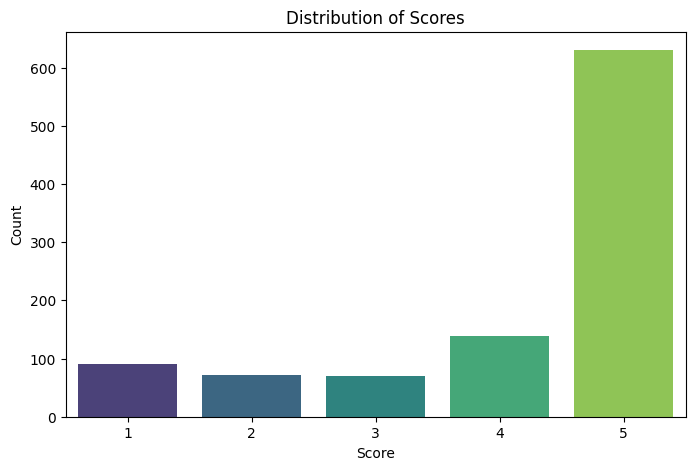

In [21]:
# Distribution of scores
# using matplotlib for the visualization
plt.figure(figsize=(8, 5))
sns.countplot(x='Score', data=df, palette='viridis')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

WORD CLOUD FOR THE REVIEWS/TEXTS

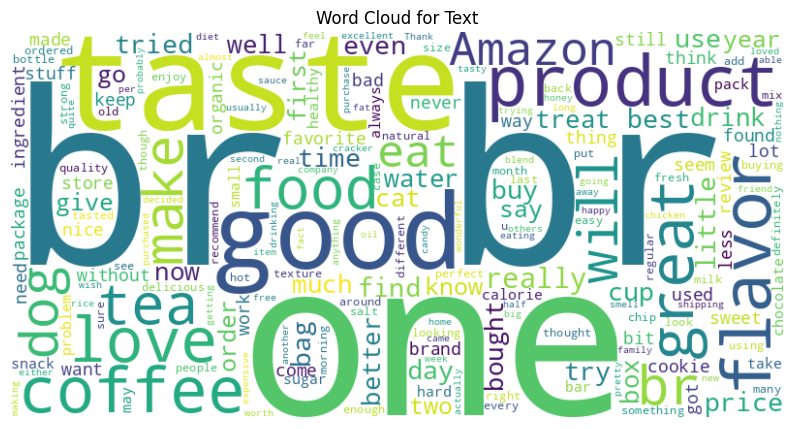

In [22]:
# Word cloud for the 'Text' column
text_reviews = ' '.join(df['Text'].dropna().values)
wordcloud_reviews = WordCloud(width=800, height=400, background_color='white').generate(text_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_reviews, interpolation='bilinear')
plt.title('Word Cloud for Text')
plt.axis('off')
plt.show()


CHART INDICATING THE TEXT LENGTHS FREQUENCIES

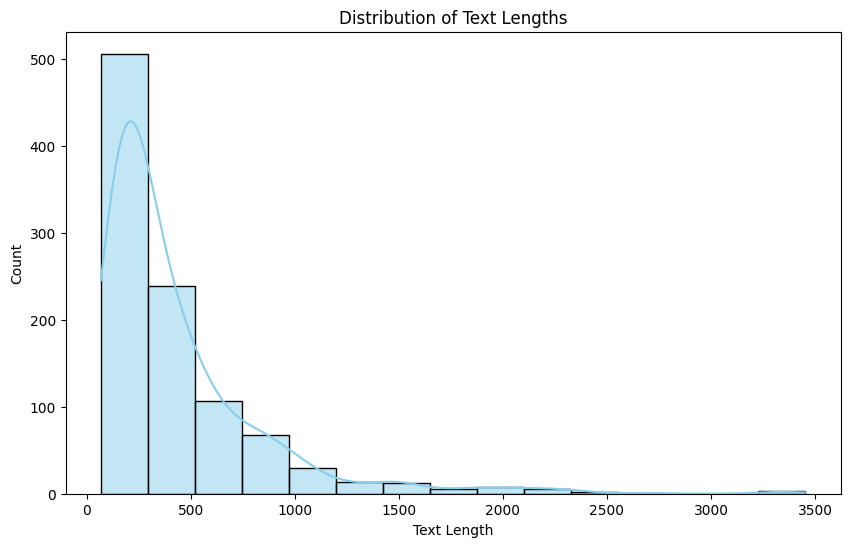

In [23]:
# Distribution of text lengths
df['Text_Length'] = df['Text'].apply(lambda x: len(str(x)))
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Text_Length', bins=15, kde=True, color='skyblue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()


## C. **Contextual Entity Sentiment Analysis with spaCy and BERT**

In [35]:
df = df[[ 'Summary', 'Text', 'Score', 'Sentiment_label','Text_Length']]

In [38]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Assign the 'Text' column from the dataframe to texts
texts = df['Text'].tolist()

# Process texts in batch with spaCy, to make the code run faster
docs = list(nlp.pipe(texts))

entities_sentiments = []

# Process entities and perform sentiment analysis
for i, doc in enumerate(docs):
    for entity in doc.ents:
        entity_text = entity.text

        # Extract context around the entity (window size)
        start_idx = max(0, entity.start - 5)
        end_idx = min(len(doc), entity.end + 5)
        entity_context = doc[start_idx:end_idx].text

        # Perform sentiment analysis with BERT
        sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
        result = sentiment_analyzer(entity_context)[0]

        # Append results to the list
        entities_sentiments.append({
            'entity': entity_text,
            'entity_label': entity.label_,
            'entity_sentiment_label': result['label'],
            'confidence_score': result['score'],
            'entity_context': entity_context
        })

# Create a new DataFrame with the sentiment analysis results
sentiment_df = pd.DataFrame(entities_sentiments)

# Print or use sentiment_df as needed
sentiment_df


,entity,entity_label,entity_sentiment_label,confidence_score,entity_context
0,9,CARDINAL,NEGATIVE,0.972458,now have a box with 9 remaining bars that I would
1,first,ORDINAL,NEGATIVE,0.989725,after I have had my first bite. Can't
2,Chew Minis,PERSON,POSITIVE,0.997890,Smart Bones Peanut Butter Dog Chew Minis...you...
3,graham,PERSON,POSITIVE,0.795804,tastes exactly the same as graham crackers you...
4,graham,PERSON,NEGATIVE,0.706157,These are more like graham flavored shortbrea...
...,...,...,...,...,...
2961,years,DATE,POSITIVE,0.999859,have been using Senseo for years and I love it.
2962,Espresso,PERSON,POSITIVE,0.959612,came out with these new Espresso pods and thou...
2963,years,DATE,NEGATIVE,0.999065,immediately. It looked like years old brown dr...
2964,Twist,NORP,NEGATIVE,0.964359,that can go in the Twist toy.



In the sentiment_df, 'Confidence score': Represents the confidence strength associated with the predicted sentiment. This score provides a quantitative measure of the sentiment intensity, ranging from 0 to 1. Higher scores typically indicate stronger intenisity of either the positive or negative sentiment.

## C. **Comparative Sentiment Analysis of Similar Entities**

### Word Clouds for Entities

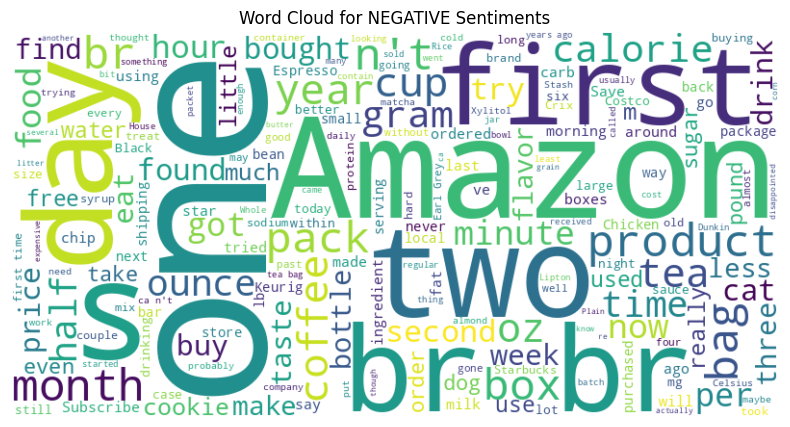

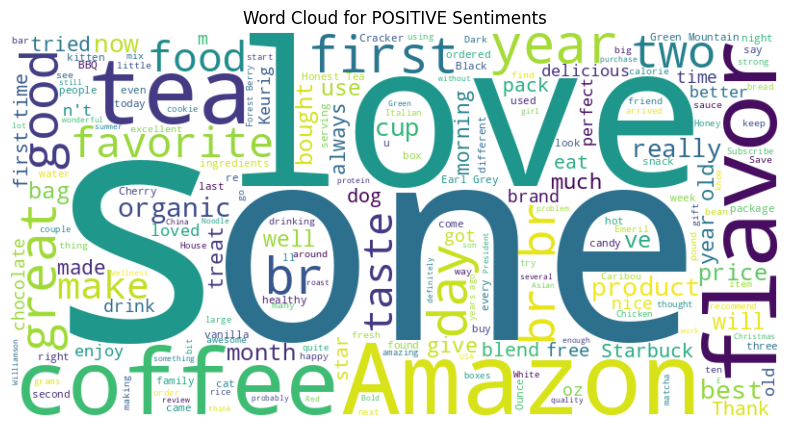

In [52]:

# Create a dictionary to store words associated with each sentiment
sentiment_words = defaultdict(list)

# Extract words for each sentiment
for _, row in sentiment_df.iterrows():
    words = [token.text for token in nlp(row['entity_context'])]
    sentiment_words[row['entity_sentiment_label']].extend(words)

# Generate Word Clouds for each sentiment
for sentiment_label, words in sentiment_words.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment_label} Sentiments')
    plt.axis('off')
    plt.show()


### Most Frequently Appeared Entities


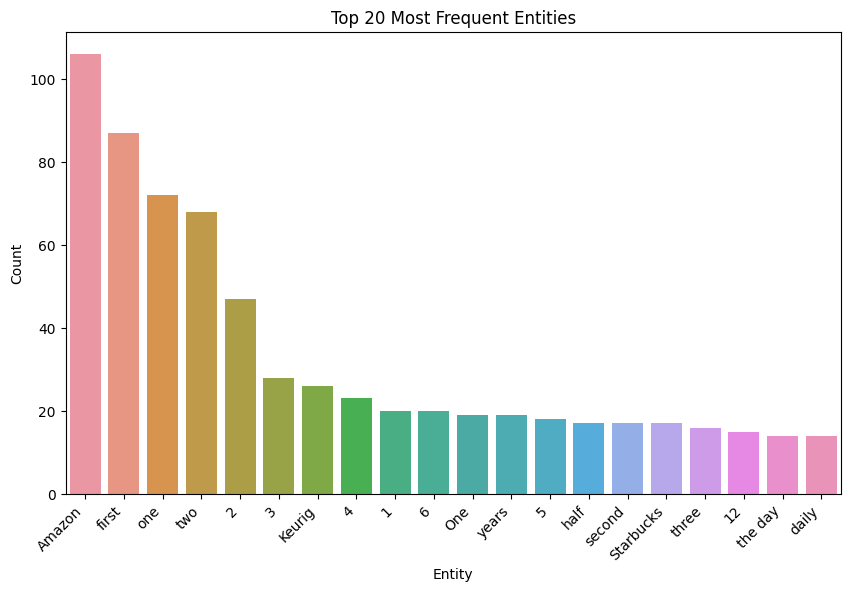

In [46]:

# Get the top 20 most frequent entities
top_entities = sentiment_df['entity'].value_counts().head(20).index

# Visualize the 20 most frequent entities
plt.figure(figsize=(10, 6))
sns.countplot(x='entity', data=sentiment_df, order=top_entities)
plt.title('Top 20 Most Frequent Entities')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


### Group by Entities and Comparison of their Average and Individual Confidence Scores

In [45]:

# Get the top 20 most frequent entities
top_entities = sentiment_df['entity'].value_counts().head(10).index

# Iterate over the top entities
for entity in top_entities:
    group = sentiment_df[sentiment_df['entity'] == entity]

    print(f"Entity: {entity}")
    print(f"Average confidence Score: {group['confidence_score'].mean()}")
    print("Individual confidence Scores:")

    for idx, row in group.iterrows():
        print(f"  Context: {row['entity_context']}")
        print(f"  confidence Score: {row['confidence_score']}")

    print("\n")


Entity: Amazon
Average confidence Score: 0.9565690480313211
Individual confidence Scores:
  Context: of purchasing this product from Amazon is amazing.  You
  confidence Score: 0.9998534917831421
  Context: find this product here on Amazon for a good price.
  confidence Score: 0.9041704535484314
  Context: never to return.  Amazon fortunately had them, but
  confidence Score: 0.942920446395874
  Context: buy it in bulk from Amazon!!
  confidence Score: 0.8294979333877563
  Context: and paying shipping. Now Amazon has then with Amazon Prime
  confidence Score: 0.8693575263023376
  Context: Now Amazon has then with Amazon Prime. Not as wide
  confidence Score: 0.9981016516685486
  Context: as wide a selection with Amazon as with Herr's,
  confidence Score: 0.5062649250030518
  Context: the past and found that Amazon offered them for about $
  confidence Score: 0.9968057870864868
  Context: packaged for shipping, since Amazon likes to just toss things
  confidence Score: 0.996693134307861

### The Similarities between the Entities

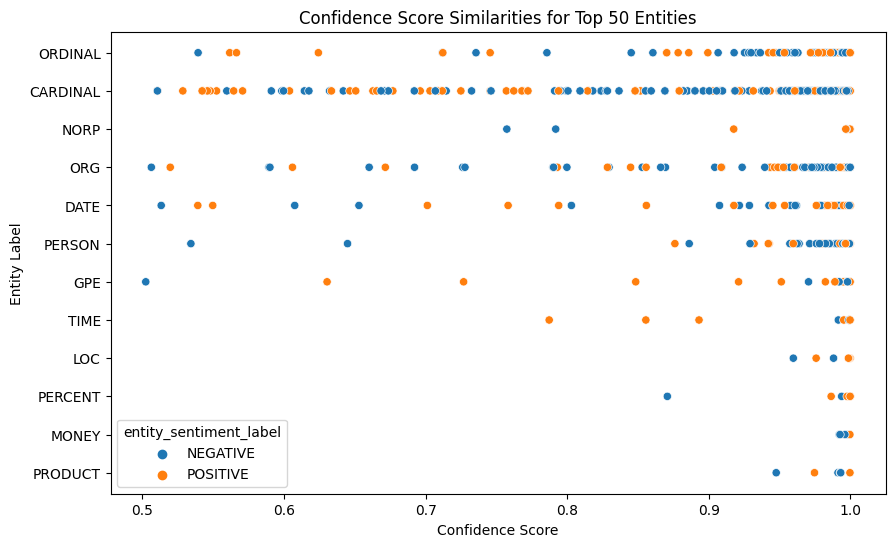

In [50]:

# Get the first 50 most frequent entities
top_entities = sentiment_df['entity'].value_counts().head(50).index

# Visualize confidence score similarities for the first 50 entities
plt.figure(figsize=(10, 6))
sns.scatterplot(x='confidence_score', y='entity_label', hue='entity_sentiment_label', data=sentiment_df[sentiment_df['entity'].isin(top_entities)])
plt.title('Confidence Score Similarities for Top 50 Entities')
plt.xlabel('Confidence Score')
plt.ylabel('Entity Label')
plt.show()



### Sentiment Heatmaps


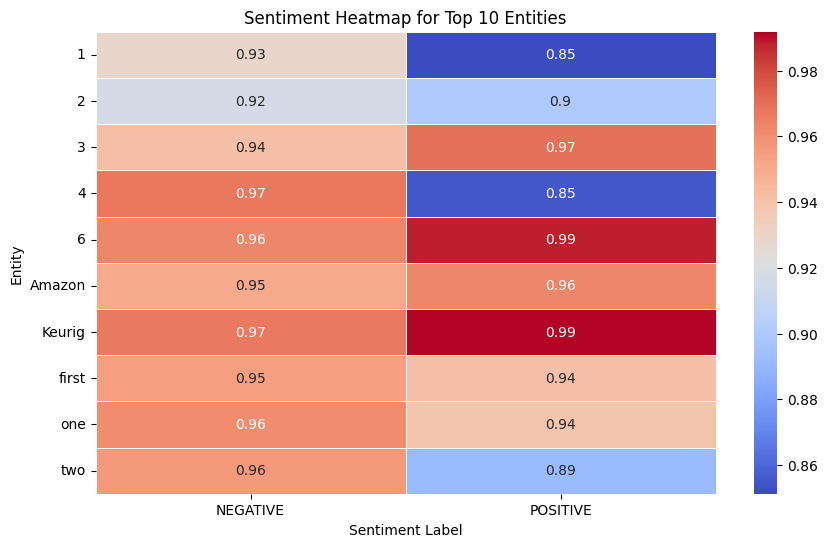

In [55]:
# Get the first 10 most frequent entities
top_entities = sentiment_df['entity'].value_counts().head(10).index

# Create a pivot table for heatmap
heatmap_data = sentiment_df[sentiment_df['entity'].isin(top_entities)].pivot_table(
    index='entity', columns='entity_sentiment_label', values='confidence_score', aggfunc='mean'
)

# Generate Sentiment Heatmap for the first 50 entities
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Sentiment Heatmap for Top 10 Entities')
plt.xlabel('Sentiment Label')
plt.ylabel('Entity')
plt.show()


The intensity of the colors on the heat map indicates the degree of confidence, with red hues indicating a strong positive correlation and blue hues indicating a strong negative correlation.


Thank you !